# Locations Search for New Coffee Shops
#### Applied Data Science Capstone Project

## Table of Contents
    
1. <a href="#Introduction">Introduction</a>

2. <a href="#Preparing Data">Preparing Data</a>

3. <a href="#Analysis">Analysis</a>

##  Introduction
This notebook contains the analysis for the final applied data science capstone project. It entails four parts. The first one is data preparation and processing, the second focus on answering the question how many coffee shops are per area in London, the second explores all areas and tries to segment them, and finally an attempt to explore other coffee shop features, such as price range and ratings is made.

##  Preparing Data
In this section we prepare data further analysis. First we scrap postcode districts and their coordinates from Wikipedia and Free Map Tools respectively, and then we utilize this to obtain venue info from the Foursquare API.

In [1]:
# Import libraries & set options

import pandas as pd # Load pandas
import numpy as np # Load numpy

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### Import London district info & postcodes from wikipedia
We use pandas to scrap postcode districts info from wikipedia. Four different data frames must be created initially, one for each area, i.e. Western, Western Central, South Eastern and South Western. Then create a union.

In [2]:
# Scrap info for Western London
w_url = "https://en.wikipedia.org/wiki/W_postcode_area"
table = pd.read_html(w_url, index_col=0, attrs={"class":"wikitable"}) # Read table
lond_w = pd.DataFrame(table[0]).reset_index()
lond_w.head()

,Postcode district,Post town,Coverage,Local authority area
0,W1A,LONDON,PO boxes & Admail codes in W1[7],non-geographic
1,W1B,LONDON,"Portland Place, Regent Street",Westminster
2,W1C,LONDON,Oxford Street (west),Westminster
3,W1D,LONDON,"Soho (south east); Chinatown, Soho Square",Westminster
4,W1F,LONDON,Soho (north west),Westminster


In [3]:
# Check size of the data frame
lond_w.shape

(26, 4)

In [4]:
# Scrap info for Western Central
wc_url = "https://en.wikipedia.org/wiki/WC_postcode_area"
table = pd.read_html(wc_url, index_col=0, attrs={"class":"wikitable"}) # Read table
lond_wc = pd.DataFrame(table[0]).reset_index()
lond_wc.head()

,Postcode district,Post town,Coverage,Local authority area
0,WC1A,LONDON,New Oxford Street,Camden
1,WC1B,LONDON,"Bloomsbury, British Museum, Southampton Row",Camden
2,WC1E,LONDON,"University College London, SOAS",Camden
3,WC1H,LONDON,"St Pancras, UCL Institute of Education",Camden
4,WC1N,LONDON,"Russell Square, Great Ormond Street",Camden


In [5]:
# Check size of the data frame
lond_wc.shape

(14, 4)

In [6]:
# Scrap info for South Eastern 
se_url = "https://en.wikipedia.org/wiki/SE_postcode_area"
table = pd.read_html(se_url, index_col=0, attrs={"class":"wikitable"}) # Read table
lond_se = pd.DataFrame(table[0]).reset_index()
lond_se.head()

,Postcode district,Post town,Coverage,Local authority area
0,SE1,LONDON,"South Eastern head district: Bankside, South B...","Lambeth, Southwark"
1,SE1P,LONDON,NaN,non-geographic
2,SE2,LONDON,"Abbey Wood district: Abbey Wood, West Heath, C...","Bexley, Greenwich"
3,SE3,LONDON,"Blackheath district: Blackheath, Kidbrooke, We...","Greenwich, Lewisham"
4,SE4,LONDON,"Brockley district: Brockley, Crofton Park",Lewisham


In [7]:
# Check size of the data frame
lond_se.shape

(29, 4)

In [8]:
# Scrap info for South Western 
sw_url = "https://en.wikipedia.org/wiki/SW_postcode_area"
table = pd.read_html(sw_url, index_col=0, attrs={"class":"wikitable"}) # Read table
lond_sw = pd.DataFrame(table[0]).reset_index()
lond_sw.head()

,Postcode district,Post town,Coverage,Local authority area
0,SW1A,LONDON,Whitehall and Buckingham Palace,Westminster
1,SW1E,LONDON,between Buckingham Gate and Victoria Station,Westminster
2,SW1H,LONDON,east of Buckingham Gate,Westminster
3,SW1P,LONDON,"triangular area between Victoria Station, the ...",Westminster
4,SW1V,LONDON,"triangular area between Vauxhall Bridge, Chels...",Westminster


In [9]:
# Check size of the data frame
lond_sw.shape

(27, 4)

In [10]:
# Union tables using the concat() function from pandas
df_lond = pd.concat([lond_w,lond_wc,lond_se,lond_sw]).reset_index(drop = True)
df_lond.head(10)

,Postcode district,Post town,Coverage,Local authority area
0,W1A,LONDON,PO boxes & Admail codes in W1[7],non-geographic
1,W1B,LONDON,"Portland Place, Regent Street",Westminster
2,W1C,LONDON,Oxford Street (west),Westminster
3,W1D,LONDON,"Soho (south east); Chinatown, Soho Square",Westminster
4,W1F,LONDON,Soho (north west),Westminster
5,W1G,LONDON,Harley Street,Westminster
6,W1H,LONDON,Marylebone,Westminster
7,W1J,LONDON,"Mayfair (south), Piccadilly",Westminster
8,W1K,LONDON,"Mayfair (north), Grosvenor Square",Westminster
9,W1S,LONDON,"Mayfair (east), Hanover Square, Savile Row, Ro...",Westminster


In [11]:
# Check the size of the data frame
df_lond.shape

(96, 4)

We perform some prossesing before introducing coordinates. We drop the column post town, lines with NaN values and local authority areas which are non-geographic.

In [12]:
# Drop post town
df_lond.drop('Post town', axis = 1, inplace=True)
df_lond.head()

,Postcode district,Coverage,Local authority area
0,W1A,PO boxes & Admail codes in W1[7],non-geographic
1,W1B,"Portland Place, Regent Street",Westminster
2,W1C,Oxford Street (west),Westminster
3,W1D,"Soho (south east); Chinatown, Soho Square",Westminster
4,W1F,Soho (north west),Westminster


In [13]:
# Drop rows with NaN values
df_lond.dropna().reset_index(drop = True)
df_lond.shape

(96, 3)

In [14]:
# Drop rows with local authority area non-geographic
drop_index = df_lond[df_lond['Local authority area'] == 'non-geographic'].index

# Drop lines
df_lond.drop(drop_index, inplace=True)
df_lond.reset_index(drop = True, inplace=True)
df_lond.head()

,Postcode district,Coverage,Local authority area
0,W1B,"Portland Place, Regent Street",Westminster
1,W1C,Oxford Street (west),Westminster
2,W1D,"Soho (south east); Chinatown, Soho Square",Westminster
3,W1F,Soho (north west),Westminster
4,W1G,Harley Street,Westminster


In [15]:
# Check size again
df_lond.shape

(94, 3)

In [16]:
# Rename columns
df_lond.rename(columns = {'Postcode district' : 'Postcode', 'Coverage' : 'Districts', 'Local authority area' : 'Area'}, inplace=True)
df_lond.head()

,Postcode,Districts,Area
0,W1B,"Portland Place, Regent Street",Westminster
1,W1C,Oxford Street (west),Westminster
2,W1D,"Soho (south east); Chinatown, Soho Square",Westminster
3,W1F,Soho (north west),Westminster
4,W1G,Harley Street,Westminster


### Import coordinates
We import from Free Map Tools the coordinates for the Districts

In [17]:
# Download using wget
!wget -q -O 'postcode-outcodes.csv' https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv
print("Coordinates downloaded")

Coordinates downloaded


In [18]:
# Read file with coordinates
df_coord = pd.read_csv("postcode-outcodes.csv")
df_coord.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [19]:
# Drop id
df_coord.drop('id',axis = 1 , inplace=True)
df_coord.head()

,postcode,latitude,longitude
0,AB10,57.13514,-2.11731
1,AB11,57.13875,-2.09089
2,AB12,57.10100,-2.11060
3,AB13,57.10801,-2.23776
4,AB14,57.10076,-2.27073


In [20]:
# Rename columns
df_coord.rename(columns = {'postcode' : 'Postcode', 'latitude' : 'Latitude', 'longitude' : 'Longitude'}, inplace=True)
df_coord.head()

,Postcode,Latitude,Longitude
0,AB10,57.13514,-2.11731
1,AB11,57.13875,-2.09089
2,AB12,57.10100,-2.11060
3,AB13,57.10801,-2.23776
4,AB14,57.10076,-2.27073


### Prepare final data frame with geographical info for London districts

In [21]:
# We join df_lond & df_coord by postcode
df_lond = df_lond.join(df_coord.set_index('Postcode'), on = 'Postcode')
df_lond.head()

,Postcode,Districts,Area,Latitude,Longitude
0,W1B,"Portland Place, Regent Street",Westminster,51.51357,-0.13931
1,W1C,Oxford Street (west),Westminster,51.51371,-0.14795
2,W1D,"Soho (south east); Chinatown, Soho Square",Westminster,51.51344,-0.13066
3,W1F,Soho (north west),Westminster,51.51261,-0.13502
4,W1G,Harley Street,Westminster,51.51818,-0.14633


In [22]:
# Check the dataframe size
df_lond.shape

(94, 5)

### Visualize London districts with folium

In [23]:
# First we get the coordinates for Herne Hill (postcode SE24)

latitude = df_lond.loc[df_lond['Postcode'] == 'SE24','Latitude'].values[0]
longitude = df_lond.loc[df_lond['Postcode'] == 'SE24','Longitude'].values[0]
print('The geograpical coordinate of Herne Hill are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Herne Hill are 51.45446, -0.09852999999999999.


In [24]:
# Use folimum to generate a map with all the districts

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, area, district in zip(df_lond['Latitude'], df_lond['Longitude'], df_lond['Area'], df_lond['Districts']):
    label = '{}, {}'.format(district, area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### Import data for venues from Foursquare API
Having as main tool the API & the dataframe with info about London districts we start importing data for London venues. We will be using mostly the explorer call to get top-100 venues per district in a radius of 500 meters.

#### Set the Foursquare cretentials (hidden cell)

In [25]:
# The code was removed by Watson Studio for sharing.

In [26]:
# Define function for getting the nearby venues. 
# Default value for radius is 500 meters & LIMIT is 100

def getNearbyVenues(names, latitudes, longitudes, radius = 500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

In [27]:
# Get London Venues
london_venues =  getNearbyVenues(names=df_lond['Districts'], latitudes=df_lond['Latitude'], longitudes=df_lond['Longitude'])

Portland Place, Regent Street
Oxford Street (west)
Soho (south east); Chinatown, Soho Square
Soho (north west)
Harley Street
Marylebone
Mayfair (south), Piccadilly
Mayfair (north), Grosvenor Square
Mayfair (east), Hanover Square, Savile Row, Royal Academy
Fitzrovia, Tottenham Court Road
Marylebone
Great Portland Street, Fitzrovia
Paddington head district: Paddington, Bayswater, Hyde Park, Westbourne Green, Little Venice (part), Notting Hill (part)
Acton district: Acton, West Acton, North Acton (part), South Acton, East Acton (west), Park Royal (south), Hanger Hill Garden Estate, Gunnersbury Park
Chiswick district: Chiswick, Gunnersbury, Turnham Green, Acton Green, South Acton (part), Bedford Park
Ealing district: Ealing, South Ealing, Ealing Common, North Ealing, Northfields, (south and east), Pitshanger, Hanger Lane
Hammersmith district: Hammersmith, Ravenscourt Park, Stamford Brook (part)
Hanwell district: Hanwell, Boston Manor (part)
Kensington district: Kensington, Holland Park (pa

In [71]:
# Inspect the dataframe
london_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Portland Place, Regent Street",51.51357,-0.13931,Dishoom,51.513079,-0.139689,Indian Restaurant,55a7b3a9498e07b375ea307d
1,"Portland Place, Regent Street",51.51357,-0.13931,Liberty of London,51.513725,-0.140510,Department Store,4ac518ecf964a52072ac20e3
2,"Portland Place, Regent Street",51.51357,-0.13931,Carnaby Street,51.513210,-0.138896,Pedestrian Plaza,4ac518d0f964a52095a620e3
3,"Portland Place, Regent Street",51.51357,-0.13931,Kingly Court,51.512632,-0.138769,Food Court,4c1512aaa9c220a1b77d589d
4,"Portland Place, Regent Street",51.51357,-0.13931,We Built This City,51.512445,-0.138061,Gift Shop,557ab194498ec1b1d20cc763


In [28]:
# Get the size of the dataframe
london_venues.shape

(5252, 8)

In [29]:
# Find the total number of venues
print("The total number of venues is",london_venues.shape[0],".")

The total number of venues is 5252 .


In [30]:
# Find how many unique venue categories are present
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 310 uniques categories.


In [31]:
# Use groupby to count the venues per district
london_venues.groupby('District').count().reset_index().sort_values('Venue', ascending = False)[['District','Venue']]

,District,Venue
46,Marylebone,200
59,"Portland Place, Regent Street",100
40,"Kings Cross, Finsbury (west), Clerkenwell (north)",100
31,"Great Portland Street, Fitzrovia",100
42,"Leicester Square, St. Giles",100
44,"Lincoln's Inn Fields, Royal Courts of Justice,...",100
27,"Fitzrovia, Tottenham Court Road",100
47,"Mayfair (east), Hanover Square, Savile Row, Ro...",100
48,"Mayfair (north), Grosvenor Square",100
49,"Mayfair (south), Piccadilly",100


### Prepare final data frames
Next we will generate the data frames that we use in the analysis for coffee shops in London. These dataframes are:
* The main dataframe will entail the frequency of different venue categories per district, and will be the input for k-means
* A small dataframe will have the frequency of coffee shops and caffes per district
* A data frame will have the top-10 most common venue categories
* The last data frame will contain the average price range for coffee shops and cafes per district and if possible the average ratings

#### First we generate a data frame with venues frequencies per area

In [32]:
# Perform one hot encoding & create a column per category.
# Each row i.e. venue will have 1 only in the corresponding venue column
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# Add district column back to dataframe
london_onehot['District'] = london_venues['District']

# Move district column to the first column
fixed_columns = london_onehot.columns.tolist()
n = int(fixed_columns.index('District')) 
fixed_columns = [fixed_columns[n]] + fixed_columns[:n] + fixed_columns[n+1:] 
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,District,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Residence Hall,College Science Building,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paella Restaurant,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Road,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Scottish Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi

In [33]:
# Group by district and calculate the frequency for different venue categories for each district
london_grouped = london_onehot.groupby('District').mean().reset_index()
london_grouped.head(2)

,District,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Residence Hall,College Science Building,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paella Restaurant,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Road,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Scottish Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi

In [34]:
# Check the size
london_grouped.shape

(93, 311)

#### Generate a dataframe with districts and coffee shops & cafe frequency per district

In [35]:
# Select frequencies for cafes & coffee shops
london_cafe_freq = pd.DataFrame(london_grouped, columns=['District','Café','Coffee Shop'])
london_cafe_freq.head()

,District,Café,Coffee Shop
0,"Abbey Wood district: Abbey Wood, West Heath, C...",0.000000,0.142857
1,"Acton district: Acton, West Acton, North Acton...",0.000000,0.050000
2,"Anerley district: Anerley, Crystal Palace (par...",0.066667,0.066667
3,"Balham district: Balham, Clapham South, Wandsw...",0.037736,0.132075
4,Barnes district: Barnes,0.040000,0.080000


In [36]:
# Add the frequencies for the two venue categories
#london_cafe_freq['coffee_freq'] = london_cafe_freq[['Café','Coffee Shop']].sum(axis = 1)
london_cafe_freq['coffee_freq'] = london_cafe_freq.loc[:,['Café','Coffee Shop']].sum(axis=1, numeric_only=True)
london_cafe_freq.head()

,District,Café,Coffee Shop,coffee_freq
0,"Abbey Wood district: Abbey Wood, West Heath, C...",0.000000,0.142857,0.142857
1,"Acton district: Acton, West Acton, North Acton...",0.000000,0.050000,0.050000
2,"Anerley district: Anerley, Crystal Palace (par...",0.066667,0.066667,0.133333
3,"Balham district: Balham, Clapham South, Wandsw...",0.037736,0.132075,0.169811
4,Barnes district: Barnes,0.040000,0.080000,0.120000


In [37]:
# Drop the Cafe & Coffee Shop frequencies
london_cafe_freq.drop(['Café','Coffee Shop'], axis = 1, inplace=True)
london_cafe_freq.head()

,District,coffee_freq
0,"Abbey Wood district: Abbey Wood, West Heath, C...",0.142857
1,"Acton district: Acton, West Acton, North Acton...",0.050000
2,"Anerley district: Anerley, Crystal Palace (par...",0.133333
3,"Balham district: Balham, Clapham South, Wandsw...",0.169811
4,Barnes district: Barnes,0.120000


In [38]:
# Join with df_lond to get coordinates
london_cafe_freq = london_cafe_freq.join(df_lond.set_index('Districts'), on = 'District')
london_cafe_freq.head()

,District,coffee_freq,Postcode,Area,Latitude,Longitude
0,"Abbey Wood district: Abbey Wood, West Heath, C...",0.142857,SE2,"Bexley, Greenwich",51.48943,0.11759
1,"Acton district: Acton, West Acton, North Acton...",0.050000,W3,"Ealing, Hounslow, Hammersmith and Fulham",51.50925,-0.26775
2,"Anerley district: Anerley, Crystal Palace (par...",0.133333,SE20,Bromley,51.41151,-0.05716
3,"Balham district: Balham, Clapham South, Wandsw...",0.169811,SW12,"Wandsworth, Lambeth",51.44536,-0.14784
4,Barnes district: Barnes,0.120000,SW13,Richmond upon Thames,51.47473,-0.24458


In [39]:
# Drop postcode & area
london_cafe_freq.drop(['Area','Postcode'], axis = 1,inplace = True)
london_cafe_freq.head()

,District,coffee_freq,Latitude,Longitude
0,"Abbey Wood district: Abbey Wood, West Heath, C...",0.142857,51.48943,0.11759
1,"Acton district: Acton, West Acton, North Acton...",0.050000,51.50925,-0.26775
2,"Anerley district: Anerley, Crystal Palace (par...",0.133333,51.41151,-0.05716
3,"Balham district: Balham, Clapham South, Wandsw...",0.169811,51.44536,-0.14784
4,Barnes district: Barnes,0.120000,51.47473,-0.24458


In [40]:
# Check the dataframe size
london_cafe_freq.shape

(94, 4)

#### Generate dataframe with top-10 most common venues

In [41]:
# First we define a function to sort venues in descending order, see labs.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
# Create a dataframe with top-10 most common venue categories
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_districts_venues_sorted = pd.DataFrame(columns=columns)
top_districts_venues_sorted['District'] = london_grouped['District']

for ind in np.arange(london_grouped.shape[0]):
    top_districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

top_districts_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Wood district: Abbey Wood, West Heath, C...",Pub,Supermarket,Train Station,Coffee Shop,Convenience Store,Campground,Grocery Store,Frozen Yogurt Shop,Furniture / Home Store,Fried Chicken Joint
1,"Acton district: Acton, West Acton, North Acton...",Pub,Park,Gym / Fitness Center,Pizza Place,Sandwich Place,Chinese Restaurant,Hotel,Convenience Store,Brewery,Grocery Store
2,"Anerley district: Anerley, Crystal Palace (par...",Fast Food Restaurant,Supermarket,Pizza Place,Pub,Hotel,Shopping Mall,Café,Furniture / Home Store,Coffee Shop,Dim Sum Restaurant
3,"Balham district: Balham, Clapham South, Wandsw...",Coffee Shop,Pub,Pizza Place,Bakery,Indian Restaurant,Bar,Supermarket,Sandwich Place,Café,Pharmacy
4,Barnes district: Barnes,Pub,Grocery Store,Pizza Place,Coffee Shop,Gym / Fitness Center,Food & Drink Shop,Farmers Market,Bakery,Breakfast Spot,French Restaurant


#### Generate a dataframe with average ratings an price per district only for coffee shops and cafe
For this task will first select only venues which are coffee shops and then iterate with venue detail calls to get the price tier & ratings

In [43]:
# Select only coffee shops and exclude cafe due to Foursquare limitations with premium calls
london_cafe = pd.DataFrame(london_venues.loc[london_venues['Venue Category'].isin(['Coffee Shop'])].reset_index(drop = True))
london_cafe.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Portland Place, Regent Street",51.51357,-0.13931,Soho Grind,51.512120,-0.138284,Coffee Shop,533c55d3498e3f1588a54483
1,"Portland Place, Regent Street",51.51357,-0.13931,Department of Coffee and Social Affairs,51.513520,-0.139087,Coffee Shop,4e803da030f8a9b9d75ee8f6
2,"Portland Place, Regent Street",51.51357,-0.13931,39 Steps Coffee Haus,51.514697,-0.135926,Coffee Shop,5a85a8e77564f72447244d89
3,"Portland Place, Regent Street",51.51357,-0.13931,JOLT,51.516186,-0.140462,Coffee Shop,5c75875e1c9e2e002527a174
4,Oxford Street (west),51.51371,-0.14795,Taylor St Baristas,51.512344,-0.147339,Coffee Shop,4e7b4485887750b4e4a48cee


In [44]:
# Check size
london_cafe.shape

(309, 8)

In [45]:
# Drop columns not needed & create columns for rating and price range
london_cafe.drop(['Venue Latitude','Venue Longitude','Venue Category','Venue'], axis = 1, inplace=True)
london_cafe['price'] = float(0)
london_cafe['rating'] = float(0)
london_cafe.head()

,District,District Latitude,District Longitude,Venue ID,price,rating
0,"Portland Place, Regent Street",51.51357,-0.13931,533c55d3498e3f1588a54483,0.0,0.0
1,"Portland Place, Regent Street",51.51357,-0.13931,4e803da030f8a9b9d75ee8f6,0.0,0.0
2,"Portland Place, Regent Street",51.51357,-0.13931,5a85a8e77564f72447244d89,0.0,0.0
3,"Portland Place, Regent Street",51.51357,-0.13931,5c75875e1c9e2e002527a174,0.0,0.0
4,Oxford Street (west),51.51371,-0.14795,4e7b4485887750b4e4a48cee,0.0,0.0


In [46]:
# Perform a test to check how the venue details call works
venue_id = london_cafe['Venue ID'][0]

In [47]:
# The code was removed by Watson Studio for sharing.

In [48]:
# Send the request
result = requests.get(url).json()

In [49]:
# Get the rating
try:
    rating = result['response']['venue']['rating']
except:
    rating = float('NaN')

In [50]:
rating

8.7

In [51]:
# Get the price
try:
    price = result['response']['venue']['price']['tier']
except:
    price = float('NaN')

In [52]:
price

1

In [53]:
# Now we can loop over our dataframe and get the information we need
for index in london_cafe.index:
    venue_id = london_cafe['Venue ID'][index] # Set venue id
    
    # Prepare url
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION) 
    
    result = requests.get(url).json() # Send request
    
    # Get the rating
    try:
        rating = result['response']['venue']['rating']
        london_cafe.at[index,'rating'] = rating
    except:
        london_cafe.at[index,'rating'] = float('NaN')
        
    # Get the price range
    try:
        price = result['response']['venue']['price']['tier']
        london_cafe.at[index,'price'] = price
    except:
        london_cafe.at[index,'price'] = float('NaN')

In [54]:
# Check the data frame
london_cafe.head()

,District,District Latitude,District Longitude,Venue ID,price,rating
0,"Portland Place, Regent Street",51.51357,-0.13931,533c55d3498e3f1588a54483,1.0,8.7
1,"Portland Place, Regent Street",51.51357,-0.13931,4e803da030f8a9b9d75ee8f6,2.0,8.5
2,"Portland Place, Regent Street",51.51357,-0.13931,5a85a8e77564f72447244d89,1.0,8.7
3,"Portland Place, Regent Street",51.51357,-0.13931,5c75875e1c9e2e002527a174,1.0,8.8
4,Oxford Street (west),51.51371,-0.14795,4e7b4485887750b4e4a48cee,1.0,8.8


In [55]:
# Groupby district and calculate average price range and rating
london_cafe_grouped = london_cafe.drop(['Venue ID'], axis = 1).groupby('District').mean().reset_index()
london_cafe_grouped.head()

,District,District Latitude,District Longitude,price,rating
0,"Abbey Wood district: Abbey Wood, West Heath, C...",51.48943,0.11759,1.000000,NaN
1,"Acton district: Acton, West Acton, North Acton...",51.50925,-0.26775,1.000000,6.100000
2,"Anerley district: Anerley, Crystal Palace (par...",51.41151,-0.05716,1.000000,6.700000
3,"Balham district: Balham, Clapham South, Wandsw...",51.44536,-0.14784,1.142857,7.442857
4,Barnes district: Barnes,51.47473,-0.24458,1.000000,6.700000


In [56]:
# Check dataframe  size
london_cafe_grouped.shape

(77, 5)

##  Analysis
Now we start our analysis. First we create a map to see which areas have the highest frequency of coffee shops. Then we apply k-means to segment the areas. Finally we explore regions by analysing average price range & ratings.

### Distribution of Coffee Shops

In [57]:
# Use folimum to generate a bubble map with all the districts
# The marker size and color is proportional to the coffee shops frequency

# Create map of London using latitude and longitude values
map_coffee = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, freq in zip(london_cafe_freq['Latitude'], london_cafe_freq['Longitude'], london_cafe_freq['District'], london_cafe_freq['coffee_freq']):
    label = 'District: {}; Frequency: {}'.format(district, round(freq,2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30*freq,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffee)  
    
map_coffee

### Use k-means to segment districts
First we will use the elbow method to find the optimal number of clusters, then we will use the result to segment districts, and finally we visuallise our results

#### Prepare data

In [58]:
# Drop districts
kmeans_input = london_grouped.drop(['District'], axis = 1)
kmeans_input.head(5)

,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,College Residence Hall,College Science Building,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Paella Restaurant,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Restaurant,Road,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Scottish Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stables,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaura

#### Loop over different k to find the optimum k.

In [59]:
Sum_of_squared_distances = [] # Vector to hold sum of squared distances
K = range(1,21) # Range of k values

# Loop over k
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(kmeans_input)
    Sum_of_squared_distances.append(km.inertia_)

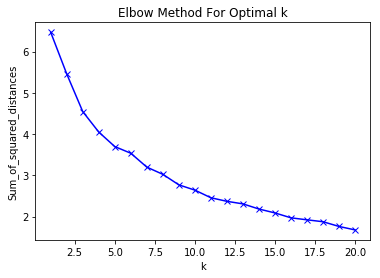

In [61]:
# Plot sum of squared distances vs k
import matplotlib.pyplot as plt # Import matplotlib

plt.plot(list(K), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Perfom clustering with optimum k.

In [80]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kmeans_input)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 2, 1, 2, 2, 2, 4, 2], dtype=int32)

#### Next we take the dataframe with the top-10 most common venue categories and add the cluster, the district and coordinates

In [81]:
# add clusters' id labels
top_districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Generate the final data frame
london_merged = df_lond
london_merged.rename(columns={'Districts':'District'},inplace=True)

# Merge with top_districts_venues_sorted to get the final dataframe
london_merged = london_merged.join(top_districts_venues_sorted.set_index('District'), on='District')

london_merged.head()

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,W1B,"Portland Place, Regent Street",Westminster,51.51357,-0.13931,2,Clothing Store,Tapas Restaurant,Coffee Shop,Cocktail Bar,Indian Restaurant,English Restaurant,Jewelry Store,Cosmetics Shop,Café,Dessert Shop
1,W1C,Oxford Street (west),Westminster,51.51371,-0.14795,2,Coffee Shop,Clothing Store,Art Gallery,French Restaurant,Hotel,Hotel Bar,Steakhouse,Café,Sandwich Place,Cosmetics Shop
2,W1D,"Soho (south east); Chinatown, Soho Square",Westminster,51.51344,-0.13066,2,Theater,Bakery,Ice Cream Shop,Coffee Shop,Hotel,Steakhouse,Comic Shop,Lounge,Arts & Crafts Store,Seafood Restaurant
3,W1F,Soho (north west),Westminster,51.51261,-0.13502,2,Cocktail Bar,Theater,Ice Cream Shop,Coffee Shop,Hotel,Steakhouse,Restaurant,Tapas Restaurant,English Restaurant,Cupcake Shop
4,W1G,Harley Street,Westminster,51.51818,-0.14633,2,Italian Restaurant,Coffee Shop,Café,Clothing Store,French Restaurant,Bakery,Hotel,Burger Joint,Pub,Hotel Bar


In [82]:
# Count number of districts per cluster
london_merged[['Cluster Labels','Postcode']].groupby('Cluster Labels').count()

,Postcode
Cluster Labels,
0,6
1,12
2,73
3,1
4,1
5,1


#### Visualize the clusters

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['District'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

#### Explore clusters

In [87]:
# Cluster 0
london_merged[london_merged['Cluster Labels'] == 0]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,SE2,"Abbey Wood district: Abbey Wood, West Heath, C...","Bexley, Greenwich",51.48943,0.11759,0,Pub,Supermarket,Train Station,Coffee Shop,Convenience Store,Campground,Grocery Store,Frozen Yogurt Shop,Furniture / Home Store,Fried Chicken Joint
44,SE6,"Catford district: Catford, Bellingham, Hither ...",Lewisham,51.43777,-0.01432,0,Turkish Restaurant,Discount Store,Grocery Store,Shopping Plaza,Yoga Studio,Forest,Fish Market,Flea Market,Flower Shop,Food & Drink Shop
46,SE8,"Deptford district: Deptford, Evelyn, Rotherhit...","Greenwich, Lewisham, Southwark",51.48118,-0.02828,0,Grocery Store,Vietnamese Restaurant,Coffee Shop,Bar,Pub,Cocktail Bar,Deli / Bodega,Italian Restaurant,Indian Restaurant,Market
56,SE18,"Woolwich district: Woolwich, Royal Arsenal, Pl...","Bexley, Greenwich",51.48391,0.07412,0,Pub,Bus Stop,Chinese Restaurant,Convenience Store,Grocery Store,Yoga Studio,Fountain,Flower Shop,Food & Drink Shop,Food Court
75,SW2,"Brixton district: Brixton Hill, Tulse Hill (pa...",Lambeth,51.44939,-0.11889,0,Grocery Store,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Pub,Caribbean Restaurant,Chinese Restaurant,Park,Bus Stop,Auto Garage,Coffee Shop
87,SW14,"Mortlake district: Mortlake, East Sheen",Richmond upon Thames,51.46514,-0.26511,0,Pub,Grocery Store,Coffee Shop,Pizza Place,Creperie,Stationery Store,Supermarket,Park,Beer Store,Café


In [88]:
# Cluster 1
london_merged[london_merged['Cluster Labels'] == 1]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,W3,"Acton district: Acton, West Acton, North Acton...","Ealing, Hounslow, Hammersmith and Fulham",51.50925,-0.26775,1,Pub,Park,Gym / Fitness Center,Pizza Place,Sandwich Place,Chinese Restaurant,Hotel,Convenience Store,Brewery,Grocery Store
32,WC1X,"Kings Cross, Finsbury (west), Clerkenwell (north)","Camden, Islington",51.52489,-0.11578,1,Pub,Coffee Shop,Italian Restaurant,Café,Vietnamese Restaurant,Hotel,History Museum,Garden,French Restaurant,Sandwich Place
39,SE1,"South Eastern head district: Bankside, South B...","Lambeth, Southwark",51.49838,-0.08949,1,Pub,Park,Italian Restaurant,Garden,Restaurant,Gym / Fitness Center,Coffee Shop,Fast Food Restaurant,Bar,Lebanese Restaurant
49,SE11,"Kennington district: Kennington, Lambeth (part...","Lambeth, Southwark",51.48880,-0.10862,1,Pub,Café,Gastropub,Coffee Shop,Fish & Chips Shop,Pizza Place,Italian Restaurant,Indian Restaurant,Theater,Bike Rental / Bike Share
61,SE23,"Forest Hill district: Forest Hill, Honor Oak, ...","Lewisham, Southwark",51.44015,-0.04875,1,Pub,Café,Pizza Place,Coffee Shop,Train Station,Gas Station,Gastropub,Grocery Store,Bookstore,Gym / Fitness Center
64,SE26,"Sydenham district: Sydenham, Crystal Palace (p...","Bromley, Lewisham, Southwark",51.42674,-0.05364,1,Portuguese Restaurant,Ice Cream Shop,Gym / Fitness Center,Coffee Shop,Park,Sandwich Place,Supermarket,Pizza Place,Caribbean Restaurant,Convenience Store
81,SW8,"South Lambeth district: South Lambeth, Wandswo...","Lambeth, Wandsworth",51.47566,-0.13077,1,Bus Stop,Portuguese Restaurant,Pub,Gym / Fitness Center,Pizza Place,Park,Performing Arts Venue,Fish & Chips Shop,Bakery,Coffee Shop
82,SW9,"Stockwell district: Brixton, Stockwell, Clapha...",Lambeth,51.46907,-0.11232,1,Pub,Portuguese Restaurant,Indian Restaurant,Skate Park,Bike Shop,Park,Bakery,Caribbean Restaurant,Music Venue,Restaurant
86,SW13,Barnes district: Barnes,Richmond upon Thames,51.47473,-0.24458,1,Pub,Grocery Store,Pizza Place,Coffee Shop,Gym / Fitness Center,Food & Drink Shop,Farmers Market,Bakery,Breakfast Spot,French Restaurant
88,SW15,"Putney district: Putney, Roehampton, Kingston ...","Wandsworth, Kingston upon Thames, Richmond upo...",51.45734,-0.22509,1,Bus Stop,Business Service,Park,Scenic Lookout,Yoga Studio,Fountain,Flower Shop,Food & Drink Shop,Food Court,Food Truck


In [89]:
# Cluster 2
london_merged[london_merged['Cluster Labels'] == 2]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,W1B,"Portland Place, Regent Street",Westminster,51.51357,-0.13931,2,Clothing Store,Tapas Restaurant,Coffee Shop,Cocktail Bar,Indian Restaurant,English Restaurant,Jewelry Store,Cosmetics Shop,Café,Dessert Shop
1,W1C,Oxford Street (west),Westminster,51.51371,-0.14795,2,Coffee Shop,Clothing Store,Art Gallery,French Restaurant,Hotel,Hotel Bar,Steakhouse,Café,Sandwich Place,Cosmetics Shop
2,W1D,"Soho (south east); Chinatown, Soho Square",Westminster,51.51344,-0.13066,2,Theater,Bakery,Ice Cream Shop,Coffee Shop,Hotel,Steakhouse,Comic Shop,Lounge,Arts & Crafts Store,Seafood Restaurant
3,W1F,Soho (north west),Westminster,51.51261,-0.13502,2,Cocktail Bar,Theater,Ice Cream Shop,Coffee Shop,Hotel,Steakhouse,Restaurant,Tapas Restaurant,English Restaurant,Cupcake Shop
4,W1G,Harley Street,Westminster,51.51818,-0.14633,2,Italian Restaurant,Coffee Shop,Café,Clothing Store,French Restaurant,Bakery,Hotel,Burger Joint,Pub,Hotel Bar
5,W1H,Marylebone,Westminster,51.51659,-0.15936,2,Hotel,Sandwich Place,Italian Restaurant,Café,French Restaurant,Restaurant,Pub,Middle Eastern Restaurant,Bakery,Salad Place
6,W1J,"Mayfair (south), Piccadilly",Westminster,51.50735,-0.14388,2,Hotel,Restaurant,Boutique,Japanese Restaurant,Seafood Restaurant,Indian Restaurant,Clothing Store,French Restaurant,Lounge,Italian Restaurant
7,W1K,"Mayfair (north), Grosvenor Square",Westminster,51.51104,-0.14950,2,Hotel,Art Gallery,Hotel Bar,Boutique,French Restaurant,Coffee Shop,Clothing Store,Cocktail Bar,Japanese Restaurant,Lounge
8,W1S,"Mayfair (east), Hanover Square, Savile Row, Ro...",Westminster,51.51090,-0.14086,2,Boutique,Clothing Store,Women's Store,Art Gallery,Indian Restaurant,Jewelry Store,Dessert Shop,Café,French Restaurant,Shoe Store
9,W1T,"Fitzrovia, Tottenham Court Road",Camden,51.51980,-0.13473,2,Coffee Shop,Bakery,Cocktail Bar,Hotel,Café,Japanese Restaurant,Pizza Place,Italian Restaurant,Furniture / Home Store,Restaurant


In [90]:
# Cluster 3
london_merged[london_merged['Cluster Labels'] == 3]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,SE9,"Eltham district: Eltham, Mottingham, New Eltha...","Bexley, Bromley, Greenwich, Lewisham",51.44465,0.05651,3,Golf Course,Yoga Studio,Fried Chicken Joint,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant


In [91]:
# Cluster 4
london_merged[london_merged['Cluster Labels'] == 4]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,SE3,"Blackheath district: Blackheath, Kidbrooke, We...","Greenwich, Lewisham",51.46866,0.02015,4,Café,Yoga Studio,Fried Chicken Joint,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant


In [92]:
# Cluster 5
london_merged[london_merged['Cluster Labels'] == 5]

,Postcode,District,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,SE12,"Lee district: Lee, Mottingham, Grove Park, Chi...","Greenwich, Lewisham, Bromley",51.4443,0.02483,5,Laundromat,Park,Yoga Studio,Fountain,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Forest


### Analysing results for price range & rating

#### A bubble map for with the average price range per district

In [93]:
# Use folimum to generate a bubble map with all the districts
# The marker size and color is proportional to the average price range per district

# Create map of London using latitude and longitude values
map_price = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, price in zip(london_cafe_grouped['District Latitude'], london_cafe_grouped['District Longitude'], london_cafe_grouped['District'], london_cafe_grouped['price']):
    label = 'District: {}; Avg. Price Range: {}'.format(district, round(price,2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5*price,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_price)  
    
map_price

#### A bubble map for with the average rating per district

In [95]:
# Use folimum to generate a bubble map with all the districts
# The marker size and color is proportional to the average rating per district

# Create map of London using latitude and longitude values
map_rating = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, rating in zip(london_cafe_grouped['District Latitude'], london_cafe_grouped['District Longitude'], london_cafe_grouped['District'], london_cafe_grouped['rating']):
    label = 'District: {}; Avg. Rating: {}'.format(district, round(rating,2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1*rating,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rating)  
    
map_rating